In [1]:
from sunpy.net import Fido, hek2vso, attrs as a
import sunpy.map
from sunpy.time import parse_time
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.coordinates import SphericalScreen
from sunpy.coordinates.utils import get_rectangle_coordinates

from astropy import units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch, AsinhStretch
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates

import os

In [2]:
lines = [94, 131, 171, 193, 211, 304, 335]
images = os.listdir('images')
aia_maps = {}
for l in lines:
    tmp = []
    for filename in images:
        if filename.find(f'{l}A') != -1:
            tmp.append(sunpy.map.Map(f'images/{filename}'))
    aia_maps[l] = sunpy.map.Map(tmp, sequence=True)


In [3]:
xin, yin = np.loadtxt('wang_in_points.csv', delimiter=',').T
xout, yout = np.loadtxt('wang_out_points.csv', delimiter=',').T

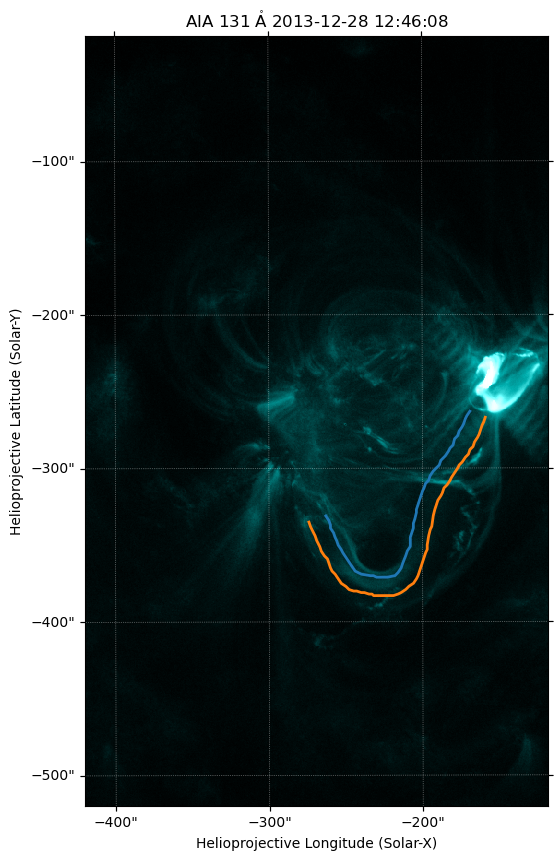

In [4]:
l = 131
n = 30
traced_in_loop = SkyCoord(
    Tx=xin*u.arcsec,
    Ty=yin*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
traced_out_loop = SkyCoord(
    Tx=xout*u.arcsec,
    Ty=yout*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_in_loop, lw=2)
ax.plot_coord(traced_out_loop, lw=2)

In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

drs = np.zeros((2,len(xin)-1))
drs[0] = np.diff(np.array(xin))
drs[1] = np.diff(np.array(yin))
ts = [v/np.linalg.norm(v) for v in drs.T]
ts.append(ts[-1])
txs, tys = np.array(ts).T
preangles = np.arctan2(tys, txs)
angles = np.append(moving_average(preangles,7), preangles[-6:])
angles

array([-1.19866712, -1.19866712, -1.17839611, -1.09439574, -1.09439574,
       -1.05635973, -1.03859473, -0.92639499, -0.85223126, -0.71765983,
       -0.57726072, -0.50309699, -0.36269789, -0.22229879, -0.15606341,
       -0.06162868,  0.07416373,  0.21456283,  0.45923332,  0.62927474,
        0.80770985,  0.94810895,  1.14430906,  1.2565088 ,  1.29454481,
        1.29454481,  1.34890286,  1.34890286,  1.39790628,  1.39790628,
        1.35194192,  1.35194192,  1.35194192,  1.30597755,  1.28570654,
        1.27473913,  1.16253939,  1.16253939,  1.12450338,  1.05826801,
        0.99203264,  1.01230365,  0.94606827,  0.97426764,  0.95399663,
        0.92579727,  1.00300005,  1.00300005,  1.00300005,  1.03119942,
        1.04896442,  1.06923543,  1.11519979,  1.06619637,  1.09439574,
        0.98279372,  1.10714872,  1.24904577,  1.10714872,  0.98279372,
        0.98279372])

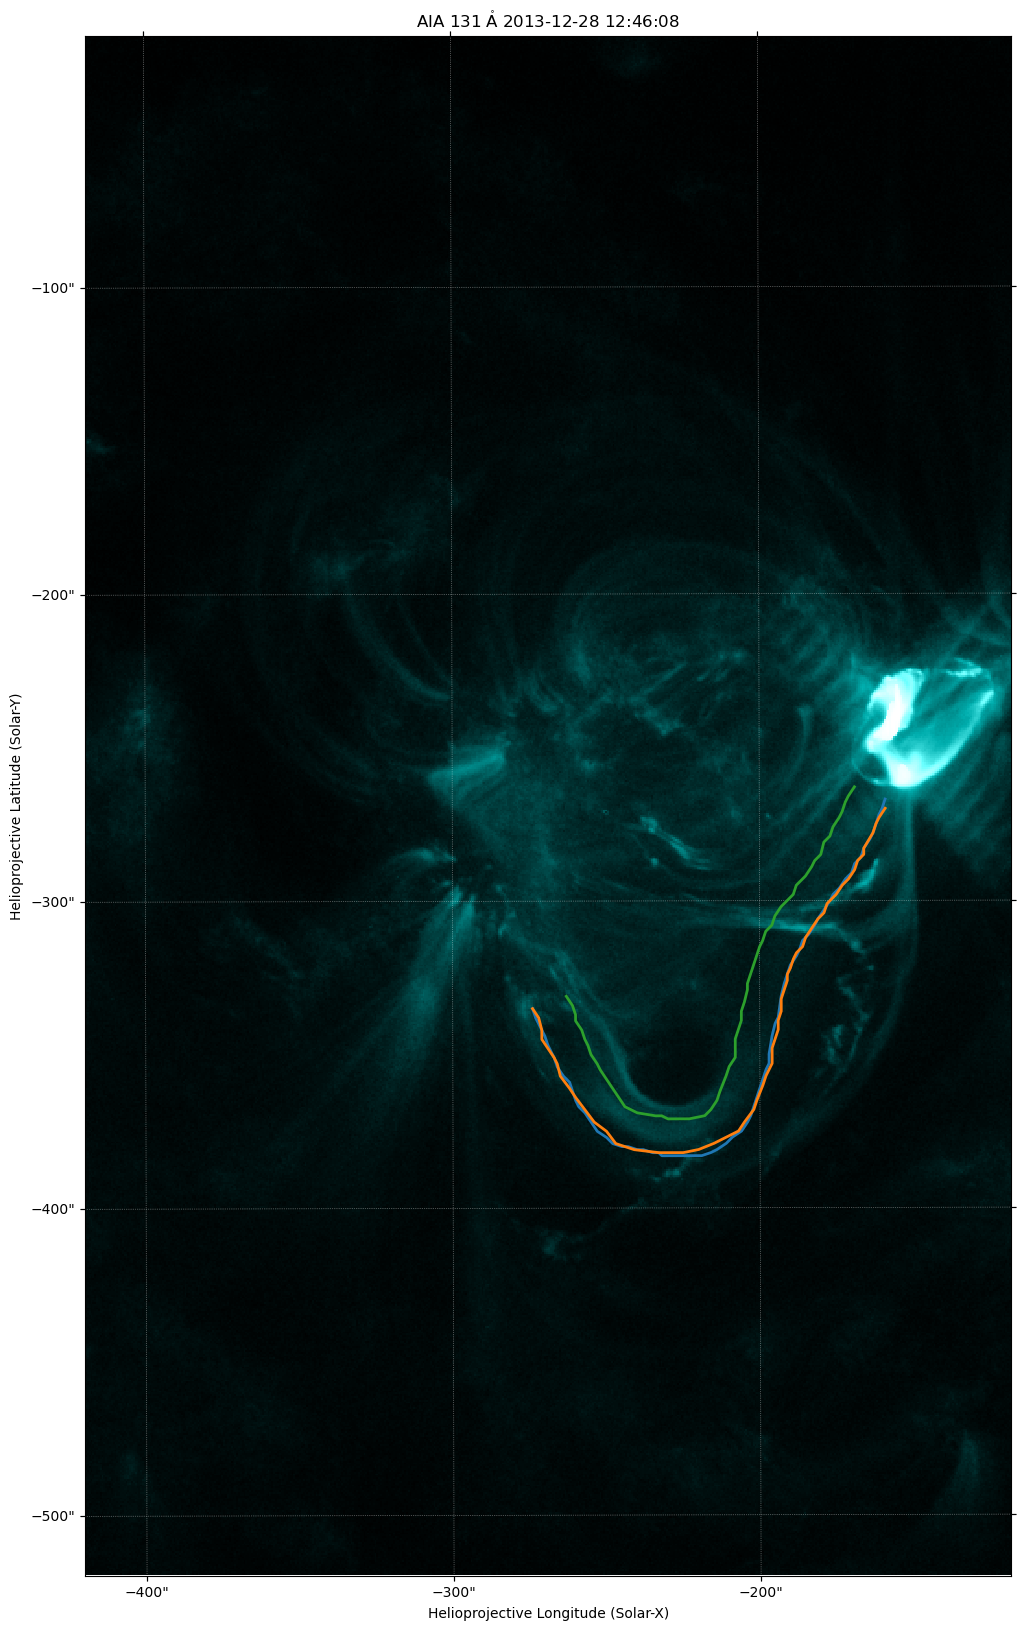

In [6]:
r = 12
x = np.round(xin + r*np.sin(angles))
y = np.round(yin - r*np.cos(angles))

traced_loop_2 = SkyCoord(
    Tx=x*u.arcsec,
    Ty=y*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(12, 20))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_out_loop, lw=2)
ax.plot_coord(traced_loop_2, lw=2)
ax.plot_coord(traced_in_loop, lw=2)

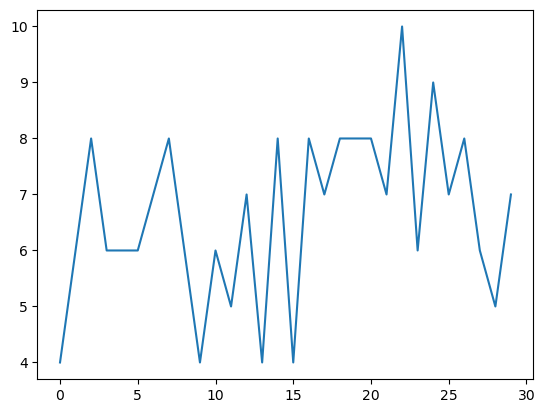

In [45]:
xout_filtered = np.zeros(len(xin))
yout_filtered = np.zeros(len(xin))
for i in range(len(x)):

    xout_filtered[i] = xout[np.argmin(np.sqrt((xout-x[i])**2+(yout-y[i])**2))]
    yout_filtered[i] = yout[np.argmin(np.sqrt((xout-x[i])**2+(yout-y[i])**2))]

# for i in range(len(xin)):
#     plt.plot([xin[i], xout_filtered[i]],[yin[i], yout_filtered[i]])
# plt.plot(xin, yin)
# plt.plot(xout_filtered, yout_filtered)
# plt.show()
height = int(np.round(np.min(np.array([np.linalg.norm(v) for v in np.array([xout_filtered-xin, yout_filtered-yin]).T])))) * u.arcsec
xs = ((xin[1::2] + xout_filtered[1::2])/2)[::-1]
ys = ((yin[1::2] + yout_filtered[1::2])/2)[::-1]
widths = np.round(np.array([np.linalg.norm(v) for v in np.array([np.diff((xin[::2] + xout_filtered[::2])/2), np.diff((yin[::2] + yout_filtered[::2])/2)]).T])[::-1]) * u.arcsec
ts = [v/np.linalg.norm(v) for v in np.array([np.diff((xin[::2] + xout_filtered[::2])/2), np.diff((yin[::2] + yout_filtered[::2])/2)]).T]
txs, tys = np.array(ts).T
preangles = np.arctan2(tys, txs)[::-1]
plt.plot(widths)

In [52]:
rectangles = []
for i in range(len(preangles)):
    center_coord = SkyCoord(xs[i] * u.arcsec, ys[i] * u.arcsec, frame=aia_maps[l][n].coordinate_frame)
    offset_frame = SkyOffsetFrame(origin=center_coord, rotation=(-preangles[i]*u.radian).to(u.degree))
    rectangles.append(SkyCoord(lon=[-1/2, 1/2] * widths[i], lat=[-1/2, 1/2] * height, frame=offset_frame))

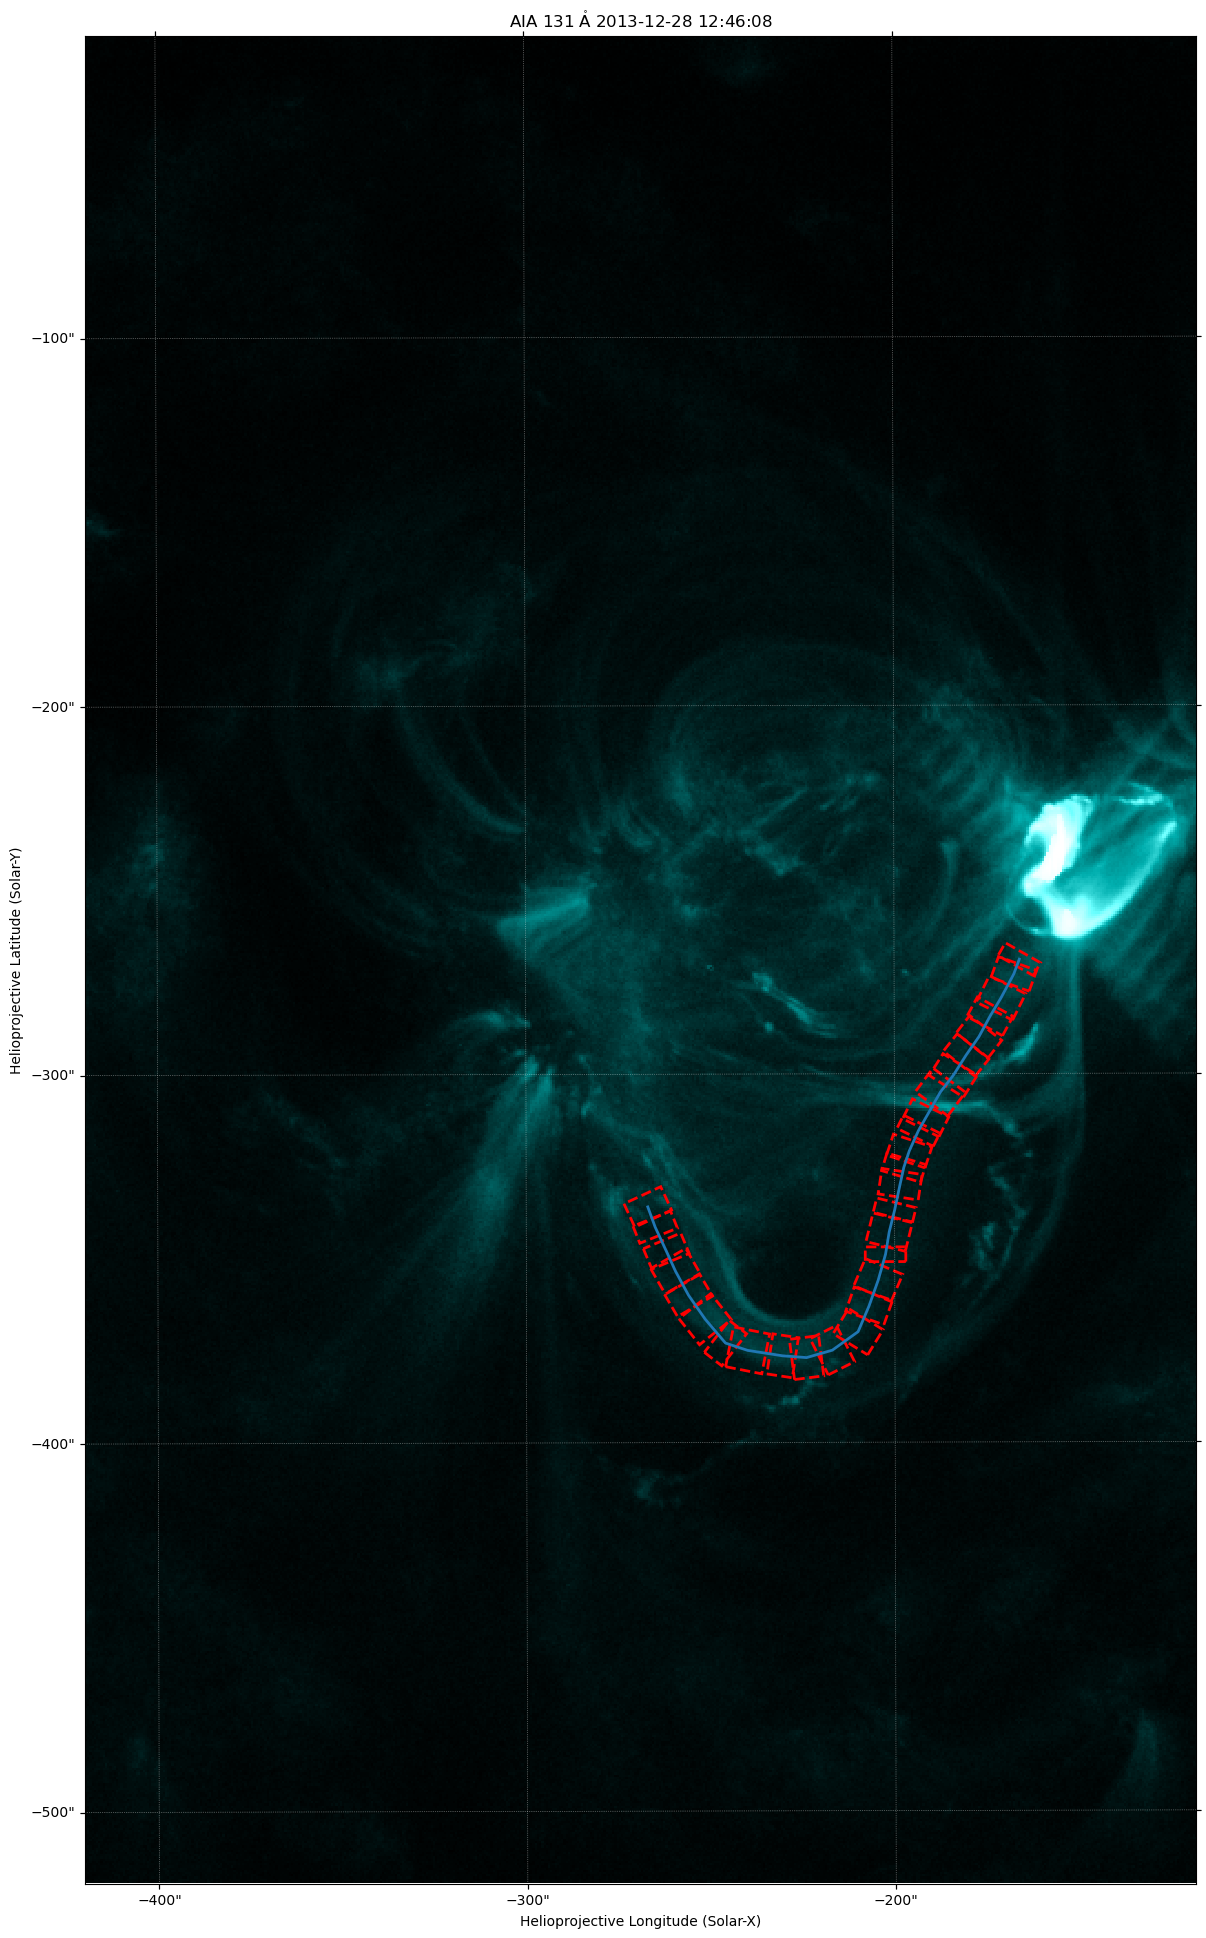

In [53]:
new_loop = SkyCoord(
    Tx=xs*u.arcsec,
    Ty=ys*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(16, 24))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(new_loop, lw=2)
for rec in rectangles:
    aia_maps[l][n].draw_quadrangle(
    rec,
    axes=ax,
    edgecolor="red",
    linestyle="--",
    linewidth=2,
)
plt.show()

In [54]:
traced_loop_distance = new_loop.separation(new_loop[0])
traced_loop_pixelated = sunpy.map.pixelate_coord_path(aia_maps[l][0], new_loop)
traced_loop_detailed_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
len(traced_loop_distance)

intensity_stack = {str(l): [] for l in lines}
for l in lines:
    for m in aia_maps[l]:
        with SphericalScreen(m.observer_coordinate):
            _recs_pixelated = [sunpy.map.pixelate_coord_path(m, rec) for rec in rectangles]
        intensity = np.array([np.mean(sunpy.map.sample_at_coords(m, rec).value) for rec in _recs_pixelated])
        f_interp = interp1d(traced_loop_distance.to_value('arcsec'), intensity, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(traced_loop_detailed_distance.to_value('arcsec'))
        intensity_stack[str(l)].append(u.Quantity(intensity_interp, u.DN/u.second))
    intensity_stack[str(l)] = u.Quantity(intensity_stack[str(l)])

[0 arcsec 0.600697 arcsec 0.849513 arcsec 1.3432 arcsec 1.89957 arcsec
 2.16584 arcsec 2.6864 arcsec 3.23485 arcsec 3.50263 arcsec 4.0296 arcsec
 4.57477 arcsec 5.13235 arcsec 5.37279 arcsec 5.91618 arcsec 6.4697 arcsec
 6.71599 arcsec 7.25824 arcsec 7.52671 arcsec 8.05919 arcsec
 8.60067 arcsec 8.86918 arcsec 9.40239 arcsec 9.9433 arcsec 10.2118 arcsec
 10.7456 arcsec 11.2861 arcsec 11.5546 arcsec 12.0888 arcsec
 12.6289 arcsec 12.8975 arcsec 13.432 arcsec 13.7112 arcsec 14.2404 arcsec
 14.7752 arcsec 15.0534 arcsec 15.5834 arcsec 16.1184 arcsec
 16.3958 arcsec 16.9264 arcsec 17.2118 arcsec 17.7384 arcsec
 18.2695 arcsec 18.5536 arcsec 19.081 arcsec 19.6125 arcsec 19.8957 arcsec
 20.4237 arcsec 20.9556 arcsec 21.2378 arcsec 21.7664 arcsec
 22.2987 arcsec 22.5801 arcsec 23.1093 arcsec 23.6418 arcsec
 23.9225 arcsec 24.4521 arcsec 24.7382 arcsec 25.265 arcsec 25.795 arcsec
 26.0802 arcsec 26.6075 arcsec 26.8975 arcsec 27.4223 arcsec
 27.7168 arcsec 28.2391 arcsec 28.7645 arcsec 29.0578 

/tmp/ipykernel_12321/3821990489.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(time_array, distance.value, intensity_stack[str(l)].value.T,


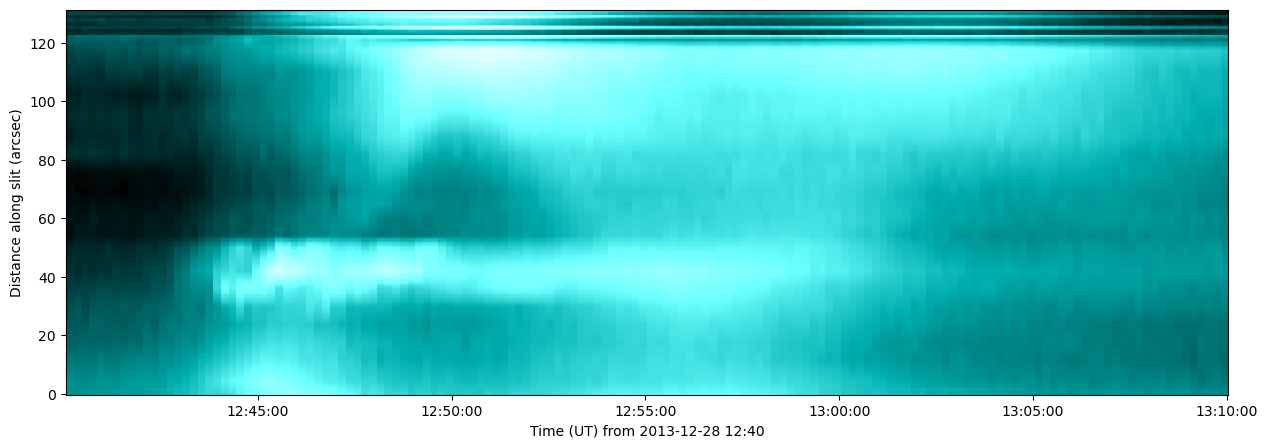

In [61]:
time_array = [m.date.datetime for m in aia_maps[l]]
distance = traced_loop_detailed_distance.to(u.arcsec)
print(distance)
l = lines[1]
# l = lines[0]
fig, ax = plt.subplots(figsize=(15, 5))
plt.pcolormesh(time_array, distance.value, intensity_stack[str(l)].value.T,
               norm=ImageNormalize(stretch=AsinhStretch()), cmap=f'sdoaia{l}')

ax.set_ylabel("Distance along slit (arcsec)")
ax.set_xlabel("Time (UT) from {:s}".format(time_array[0].strftime("%Y-%m-%d %H:%M")))
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))
plt.show()

intensity_stack['dist'] = distance.value
intensity_stack['w'] = height.value
np.savez('results_mean_line_rect.npz', **intensity_stack)